
# London House Price Prediction – Automatic Best Model Selection

This notebook implements an end‑to‑end pipeline for the **London House Price Prediction – Advanced Techniques** competition. It cleans the data, engineers features, trains multiple models (CatBoost, LightGBM, Random Forest), compares their performance via time‑aware cross‑validation, selects the model with the best RMSE, retrains it on the full training data and creates the final submission.  It also provides feature importance plots for each model and identifies the top 20 important features.


## 1. Setup and Data Loading

Install the necessary libraries (if not already installed) and load the training and test data.  Place `train.csv` and `test.csv` from the competition in the working directory.

In [8]:
! pip install catboost

In [9]:

import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans

# Supervised models
import catboost
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns

# Load data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
print(f'Train shape: {train_df.shape}')
print(f'Test shape: {test_df.shape}')


Train shape: (266325, 17)
Test shape: (16547, 16)



## 2. Remove Exact Duplicates

Remove any duplicate rows from the training data to prevent bias.


In [10]:

before = train_df.shape[0]
train_df = train_df.drop_duplicates()
after = train_df.shape[0]
print(f'Duplicate rows removed: {before - after}')


Duplicate rows removed: 0



## 3. Compute Year Index and Deflate Prices

Housing prices have trended upwards over time.  To stabilise the target, we compute a year‑specific median price index (smoothed with a rolling median) and divide the price by this index.  We then take the log of the deflated price.


In [11]:

# Compute rolling median price index by sale_year
year_median = train_df.groupby('sale_year')['price'].median()
year_index = year_median.rolling(window=2, min_periods=1).median()
year_index.name = 'year_idx'

# Attach to train and test
def attach_year_index(df):
    df = df.merge(year_index, left_on='sale_year', right_index=True, how='left')
    df['year_idx'].fillna(year_index.median(), inplace=True)
    return df

train_df = attach_year_index(train_df)
test_df = attach_year_index(test_df)

# Deflate and take log
train_df['price_deflated'] = train_df['price'] / train_df['year_idx']
train_df['log_price_defl'] = np.log1p(train_df['price_deflated'])


/tmp/ipython-input-2151147418.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['year_idx'].fillna(year_index.median(), inplace=True)
/tmp/ipython-input-2151147418.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'


## 4. Handle Missing Values and Create Area Bins

Impute missing numeric values (bathrooms, bedrooms, livingRooms, floorAreaSqM) by median within groups defined by `propertyType` and a quantile bin of floor area.  Add binary missing indicators.  Impute categorical missing values with `'Unknown'`.


In [12]:

# Create floor area quantile bins
area_quantiles = train_df['floorAreaSqM'].quantile([i/10 for i in range(1, 10)]).values
bins = [-np.inf] + area_quantiles.tolist() + [np.inf]
labels = [f'bin_{i}' for i in range(10)]
train_df['area_bin'] = pd.cut(train_df['floorAreaSqM'], bins=bins, labels=labels)
test_df['area_bin']  = pd.cut(test_df['floorAreaSqM'],  bins=bins, labels=labels)

# Impute numeric columns by group median
def impute_by_group(train_df, test_df, col, group_cols):
    group_medians = train_df.groupby(group_cols)[col].median().rename('median')
    global_median = train_df[col].median()
    def fill(df):
        return df[group_cols].join(group_medians, on=group_cols)['median'].fillna(global_median)
    # Train
    mask = train_df[col].isna()
    train_df.loc[mask, col] = fill(train_df.loc[mask])
    # Test
    mask_test = test_df[col].isna()
    test_df.loc[mask_test, col] = fill(test_df.loc[mask_test])
    return train_df, test_df

num_cols = ['bathrooms','bedrooms','livingRooms','floorAreaSqM']
for c in num_cols:
    # Add missing indicator
    train_df[f'{c}_missing'] = train_df[c].isna().astype(int)
    test_df[f'{c}_missing']  = test_df[c].isna().astype(int)
    train_df, test_df = impute_by_group(train_df, test_df, c, ['propertyType','area_bin'])

# Fill missing categorical values with 'Unknown'
for col in ['tenure','currentEnergyRating']:
    train_df[col] = train_df[col].fillna('Unknown')
    test_df[col]  = test_df[col].fillna('Unknown')


/tmp/ipython-input-1440320791.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_medians = train_df.groupby(group_cols)[col].median().rename('median')
/tmp/ipython-input-1440320791.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_medians = train_df.groupby(group_cols)[col].median().rename('median')
/tmp/ipython-input-1440320791.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_medians = train_d


## 5. Geographic Feature Engineering

Use latitude and longitude to create distance to a central point (Trafalgar Square), coarse grid tiles (`tile_id`) for target encoding, and clusters of location via k‑means.  If latitude or longitude is missing, fill with the median values from the training set.


In [13]:
# Fill missing lat/lon with medians
lat_med = train_df['latitude'].median()
lon_med = train_df['longitude'].median()
train_df['latitude_filled'] = train_df['latitude'].fillna(lat_med)
train_df['longitude_filled'] = train_df['longitude'].fillna(lon_med)
test_df['latitude_filled']  = test_df['latitude'].fillna(lat_med)
test_df['longitude_filled']  = test_df['longitude'].fillna(lon_med)

# Distance to Trafalgar Square
def haversine_distance(lat1, lon1, lat2=51.508, lon2=-0.128):
    R = 6371.0
    lat1, lon1, lat2, lon2 = np.radians(lat1), np.radians(lon1), np.radians(lat2), np.radians(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

train_df['dist_cbd_km'] = haversine_distance(train_df['latitude_filled'], train_df['longitude_filled'])
test_df['dist_cbd_km']  = haversine_distance(test_df['latitude_filled'],  test_df['longitude_filled'])

# Grid tile id
train_df['tile_id'] = (np.floor(train_df['latitude_filled']/0.01).astype(int).astype(str) + '_' + np.floor(train_df['longitude_filled']/0.01).astype(int).astype(str))
test_df['tile_id']  = (np.floor(test_df['latitude_filled']/0.01).astype(int).astype(str) + '_' + np.floor(test_df['longitude_filled']/0.01).astype(int).astype(str))

# Out-of-fold tile median price encoding
train_df['tile_price_oof'] = np.nan
kf = GroupKFold(n_splits=5)
for tr_idx, val_idx in kf.split(train_df, groups=train_df['sale_year']):
    tr_subset = train_df.iloc[tr_idx]
    val_subset = train_df.iloc[val_idx]
    tile_med = tr_subset.groupby('tile_id')['price'].median()
    train_df.loc[train_df.index[val_idx], 'tile_price_oof'] = val_subset['tile_id'].map(tile_med)

# Fill NaNs with global median price
global_price_med = train_df['price'].median()
train_df['tile_price_oof'].fillna(global_price_med, inplace=True)

# Map tile median price to test set
full_tile_med = train_df.groupby('tile_id')['price'].median()
test_df['tile_price'] = test_df['tile_id'].map(full_tile_med).fillna(global_price_med)

# K-means clustering on lat/lon
coords_train = train_df[['latitude_filled','longitude_filled']].values
coords_test  = test_df[['latitude_filled','longitude_filled']].values
kmeans = KMeans(n_clusters=40, random_state=42)
train_df['geo_cluster'] = kmeans.fit_predict(coords_train)
test_df['geo_cluster']  = kmeans.predict(coords_test)


/tmp/ipython-input-3149444002.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['tile_price_oof'].fillna(global_price_med, inplace=True)



## 6. Temporal Features

Encode the sale month cyclically using sine and cosine, and ensure `sale_year` is numeric.


In [14]:

# Ensure sale_year is integer
train_df['sale_year'] = train_df['sale_year'].astype(int)
test_df['sale_year']  = test_df['sale_year'].astype(int)

# Cyclical encoding of month
def add_cyclic_month(df):
    df['month_sin'] = np.sin(2 * np.pi * df['sale_month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['sale_month'] / 12)
    return df

train_df = add_cyclic_month(train_df)
test_df  = add_cyclic_month(test_df)



## 7. Prepare Feature Matrix and Target

Define the target `log_price_defl` and drop intermediate variables.  Keep `area_bin` as a categorical feature so it can be used as an input feature rather than just an imputation helper. Identify categorical features and prepare both raw and encoded versions of the feature matrix for different models.

In [15]:

# Target (log-deflated price)
y = train_df['log_price_defl']

# Drop columns that should not be used as features
# Note: we retain 'area_bin' as a feature
cols_to_drop = ['price','price_deflated','log_price_defl','year_idx','price_deflated']
X = train_df.drop(columns=cols_to_drop, errors='ignore')
X_test_final = test_df.drop(columns=['year_idx'], errors='ignore')

# Identify categorical and numeric columns
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in numeric_cols]

# Fill categorical missing values with 'Unknown', convert to string and then category for CatBoost
def prep_cat_for_catboost(df):
    df = df.copy()
    for col in cat_cols:
        df[col] = df[col].astype(str).fillna('Unknown')
        df[col] = df[col].astype('category')
    return df

X_cat = prep_cat_for_catboost(X)
X_test_cat = prep_cat_for_catboost(X_test_final)

# Prepare encoded version for non-catboost models: encode categories to integers
X_enc = X.copy()
X_test_enc = X_test_final.copy()
for col in cat_cols:
    all_cats = sorted(set(X_enc[col].astype(str)) | set(X_test_enc[col].astype(str)))
    X_enc[col] = pd.Categorical(X_enc[col], categories=all_cats).codes
    X_test_enc[col] = pd.Categorical(X_test_enc[col], categories=all_cats).codes

print(f'Total features: {X.shape[1]}')
print(f'Categorical features: {len(cat_cols)}')


Total features: 29
Categorical features: 9



## 8. Model Evaluation via Time‑Aware Cross‑Validation

Perform GroupKFold cross-validation for three models: **CatBoost**, **LightGBM**, and **RandomForest**.  Scores are reported in log‑deflated price space (so lower is better).  At the end, the best model will be selected for final training and prediction.


In [16]:

cv = GroupKFold(n_splits=5)

# CatBoost
cat_model_cv = catboost.CatBoostRegressor(
    iterations=2000,
    learning_rate=0.05,
    depth=8,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_state=42,
    verbose=False,
    task_type='GPU',        # <- Enables GPU
    devices='0',            # <- using Colab GPU
)
cat_scores = []

for fold, (tr_idx, val_idx) in enumerate(cv.split(X_cat, y, groups=X_cat['sale_year'])):
    X_tr, X_val = X_cat.iloc[tr_idx], X_cat.iloc[val_idx]
    y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]
    cat_model_cv.fit(
        X_tr,
        y_tr,
        cat_features=[X_cat.columns.get_loc(c) for c in cat_cols],
        eval_set=(X_val, y_val),
        verbose=200,
        early_stopping_rounds=200
    )
    pred = cat_model_cv.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    cat_scores.append(rmse)
    print(f'CatBoost Fold {fold+1} RMSE: {rmse:.5f}')

print(f"CatBoost CV RMSE: {np.mean(cat_scores):.5f} ± {np.std(cat_scores):.5f}")


0:	learn: 0.4103420	test: 0.4052039	best: 0.4052039 (0)	total: 66.5ms	remaining: 2m 12s
200:	learn: 0.1877604	test: 0.1871742	best: 0.1871742 (200)	total: 7.13s	remaining: 1m 3s
400:	learn: 0.1787566	test: 0.1823373	best: 0.1823373 (400)	total: 14.1s	remaining: 56.1s
600:	learn: 0.1728918	test: 0.1799993	best: 0.1799993 (600)	total: 20.9s	remaining: 48.7s
800:	learn: 0.1684816	test: 0.1785721	best: 0.1785702 (798)	total: 27.8s	remaining: 41.6s
1000:	learn: 0.1645679	test: 0.1775152	best: 0.1775152 (1000)	total: 34.8s	remaining: 34.7s
1200:	learn: 0.1612582	test: 0.1768626	best: 0.1768626 (1200)	total: 41.7s	remaining: 27.8s
1400:	learn: 0.1582579	test: 0.1763114	best: 0.1763114 (1400)	total: 48.6s	remaining: 20.8s
1600:	learn: 0.1554458	test: 0.1757490	best: 0.1757490 (1600)	total: 55.5s	remaining: 13.8s
1800:	learn: 0.1529068	test: 0.1752973	best: 0.1752971 (1791)	total: 1m 2s	remaining: 6.9s
1999:	learn: 0.1505218	test: 0.1750774	best: 0.1750701 (1993)	total: 1m 9s	remaining: 0us
bes

In [17]:
# LightGBM
lgb_model_cv = LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=-1,
    random_state=42,
    subsample=0.8,
    colsample_bytree=0.8
)
lgb_scores = []

for fold, (tr_idx, val_idx) in enumerate(cv.split(X_enc, y, groups=X_cat['sale_year'])):
    X_tr, X_val = X_enc.iloc[tr_idx], X_enc.iloc[val_idx]
    y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]
    lgb_model_cv.fit(
        X_tr,
        y_tr,
        categorical_feature=[X_enc.columns.get_loc(c) for c in cat_cols],
        eval_set=[(X_val, y_val)],
        callbacks=[] # Replaced verbose=False with callbacks=[]
    )
    pred = lgb_model_cv.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    lgb_scores.append(rmse)
    print(f'LightGBM Fold {fold+1} RMSE: {rmse:.5f}')

print(f"LightGBM CV RMSE: {np.mean(lgb_scores):.5f} ± {np.std(lgb_scores):.5f}")

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 53474
[LightGBM] [Info] Number of data points in the train set: 212792, number of used features: 28
[LightGBM] [Info] Start training from score 0.817357
LightGBM Fold 1 RMSE: 0.17761
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[L

In [18]:
# RandomForest
rf_model_cv = RandomForestRegressor(
    n_estimators=400,
    random_state=42,
    n_jobs=-1
)
rf_scores = []

for fold, (tr_idx, val_idx) in enumerate(cv.split(X_enc, y, groups=X_cat['sale_year'])):
    X_tr, X_val = X_enc.iloc[tr_idx], X_enc.iloc[val_idx]
    y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]
    rf_model_cv.fit(X_tr, y_tr)
    pred = rf_model_cv.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    rf_scores.append(rmse)
    print(f'RandomForest Fold {fold+1} RMSE: {rmse:.5f}')

print(f"RandomForest CV RMSE: {np.mean(rf_scores):.5f} ± {np.std(rf_scores):.5f}")

RandomForest Fold 1 RMSE: 0.18292
RandomForest Fold 2 RMSE: 0.18232
RandomForest Fold 3 RMSE: 0.17823
RandomForest Fold 4 RMSE: 0.18024
RandomForest Fold 5 RMSE: 0.18410
RandomForest CV RMSE: 0.18156 ± 0.00208



## 9. Select Best Model and Train on Full Data

Compare the average CV RMSE of CatBoost, LightGBM and RandomForest.  Select the model with the lowest mean RMSE.  Retrain that model on the full training data and generate predictions for the test set.  Predictions are re‑inflated to the original price scale and saved to a submission file.


In [19]:
# Compute mean CV RMSEs
mean_scores = {
    'CatBoost': np.mean(cat_scores),
    'LightGBM': np.mean(lgb_scores),
    'RandomForest': np.mean(rf_scores)
}

best_model_name = min(mean_scores, key=mean_scores.get)
print('Best model based on CV RMSE:', best_model_name, mean_scores[best_model_name])

# Train the chosen model on full data and predict
if best_model_name == 'CatBoost':
    # Ensure column names match between training and test data
    X_test_cat_aligned = X_test_cat.rename(columns={'tile_price': 'tile_price_oof'})
    final_model = catboost.CatBoostRegressor(
        iterations=2000,
        learning_rate=0.05,
        depth=8,
        loss_function='RMSE',
        eval_metric='RMSE',
        random_state=42,
        verbose=False,
        task_type='GPU'       # <- Enables GPU
    )
    final_model.fit(
        X_cat,
        y,
        cat_features=[X_cat.columns.get_loc(c) for c in cat_cols],
        verbose=200,
        early_stopping_rounds=200
    )
    test_pred_log = final_model.predict(X_test_cat_aligned)

elif best_model_name == 'LightGBM':
    # Ensure column names match between training and test data
    X_test_enc_aligned = X_test_enc.rename(columns={'tile_price': 'tile_price_oof'})
    final_model = LGBMRegressor(
        n_estimators=2000,
        learning_rate=0.05,
        max_depth=-1,
        random_state=42,
        subsample=0.8,
        colsample_bytree=0.8
    )
    final_model.fit(
        X_enc,
        y,
        categorical_feature=[X_enc.columns.get_loc(c) for c in cat_cols]
    )
    test_pred_log = final_model.predict(X_test_enc_aligned)

else:  # RandomForest
    # Ensure column names match between training and test data
    X_test_enc_aligned = X_test_enc.rename(columns={'tile_price': 'tile_price_oof'})
    final_model = RandomForestRegressor(
        n_estimators=400,
        random_state=42,
        n_jobs=-1
    )
    final_model.fit(X_enc, y)
    test_pred_log = final_model.predict(X_test_enc_aligned)

# Re-inflate predictions
pred_price_defl = np.expm1(test_pred_log)
pred_price = pred_price_defl * test_df['year_idx'].values

# Create submission
target_id = 'Id' if 'Id' in test_df.columns else test_df.columns[0]
submission = pd.DataFrame({
    target_id: test_df[target_id],
    'price': pred_price
})
submission.to_csv('submission.csv', index=False)
print('Saved submission.csv; best model used:', best_model_name)
submission.head()

Best model based on CV RMSE: CatBoost 0.17830217320955755
0:	learn: 0.4091769	total: 61.5ms	remaining: 2m 2s
200:	learn: 0.1869349	total: 7.82s	remaining: 1m 9s
400:	learn: 0.1781641	total: 15.4s	remaining: 1m 1s
600:	learn: 0.1727018	total: 23.1s	remaining: 53.8s
800:	learn: 0.1685853	total: 30.8s	remaining: 46.2s
1000:	learn: 0.1652466	total: 38.5s	remaining: 38.4s
1200:	learn: 0.1622373	total: 46.3s	remaining: 30.8s
1400:	learn: 0.1593963	total: 54.1s	remaining: 23.1s
1600:	learn: 0.1568884	total: 1m 1s	remaining: 15.4s
1800:	learn: 0.1546318	total: 1m 9s	remaining: 7.73s
1999:	learn: 0.1525718	total: 1m 17s	remaining: 0us
Saved submission.csv; best model used: CatBoost


,ID,price
0,266325,239891.851473
1,266326,212845.307265
2,266327,126610.911738
3,266328,274061.809701
4,266329,221726.643533



## 10. Feature Importance for Each Model

Plot the top 20 feature importances for CatBoost, LightGBM, and RandomForest models based on their full‑data training.  These plots help understand which variables most influence each model's predictions.


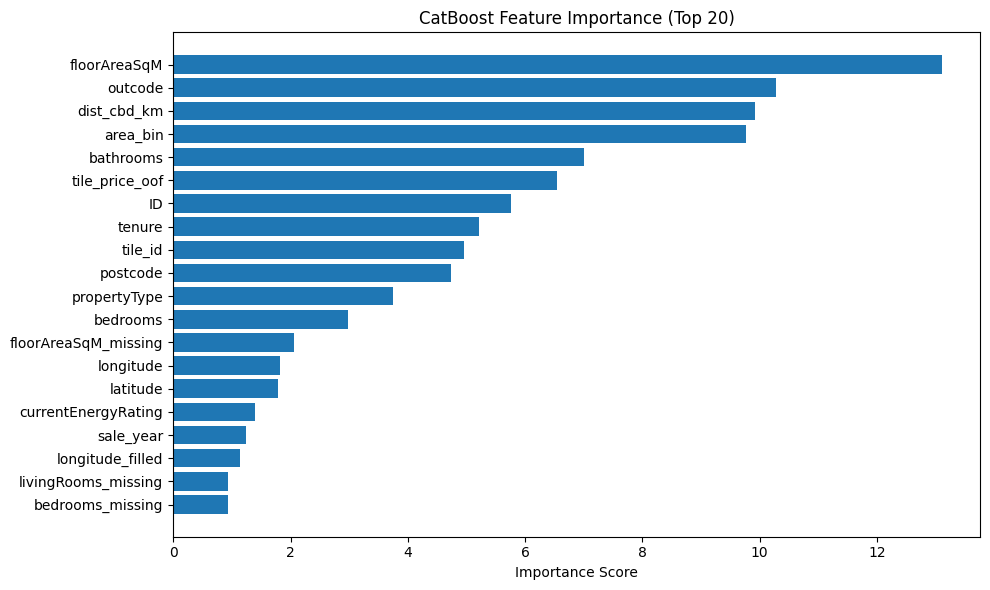

/tmp/ipython-input-2707500046.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=lgb_df.head(20), palette='viridis')


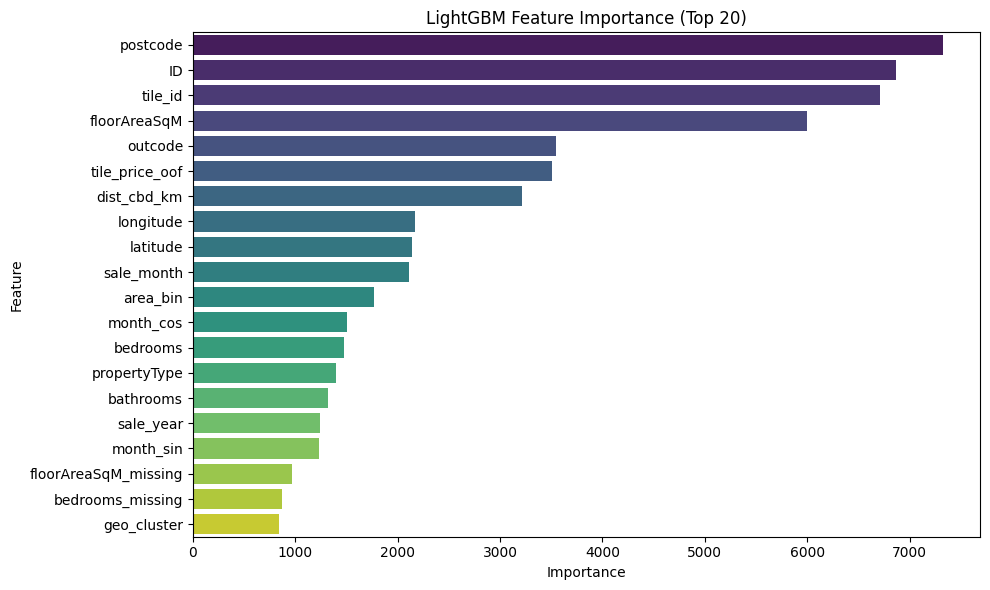

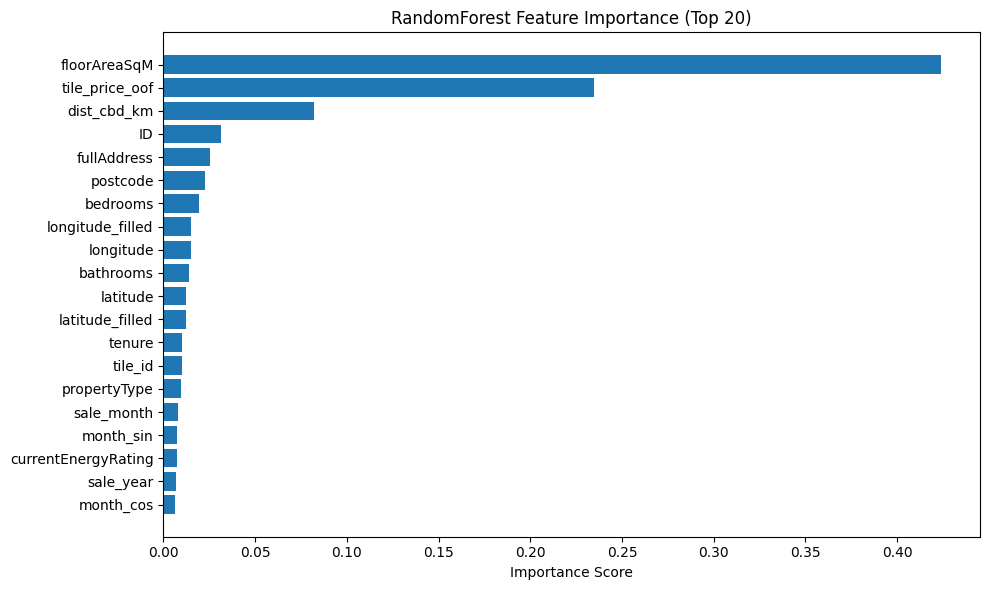

In [20]:

# CatBoost feature importance
cat_importance = final_model.get_feature_importance() if best_model_name == 'CatBoost' else cat_model_cv.get_feature_importance()
cat_df = pd.DataFrame({'Feature': X.columns, 'Importance': cat_importance}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(cat_df['Feature'][:20][::-1], cat_df['Importance'][:20][::-1])
plt.xlabel('Importance Score')
plt.title('CatBoost Feature Importance (Top 20)')
plt.tight_layout()
plt.show()

# LightGBM feature importance (use CV model if not final model)
lgb_importance = lgb_model_cv.feature_importances_
lgb_df = pd.DataFrame({'Feature': X_enc.columns, 'Importance': lgb_importance}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=lgb_df.head(20), palette='viridis')
plt.title('LightGBM Feature Importance (Top 20)')
plt.tight_layout()
plt.show()

# RandomForest feature importance
rf_importance = rf_model_cv.feature_importances_
rf_df = pd.DataFrame({'Feature': X_enc.columns, 'Importance': rf_importance}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(rf_df['Feature'][:20][::-1], rf_df['Importance'][:20][::-1])
plt.title('RandomForest Feature Importance (Top 20)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()


In [25]:
# Combine feature importances from all models
combined_importance = pd.DataFrame({
    'CatBoost': cat_df.set_index('Feature')['Importance'],
    'LightGBM': lgb_df.set_index('Feature')['Importance'],
    'RandomForest': rf_df.set_index('Feature')['Importance']
})

# Fill any missing values (features not present in all models)
combined_importance = combined_importance.fillna(0)

# Drop the 'ID' row
combined_importance = combined_importance.drop('ID', errors='ignore')

# Calculate the average importance across models
combined_importance['Average_Importance'] = combined_importance.mean(axis=1)

# Sort by average importance and get top 5
top_4_features = combined_importance.sort_values(by='Average_Importance', ascending=False).head(5)

print("\nTop 4 Most Important Features (Average Importance across Models, excluding ID):")
print(top_4_features[['Average_Importance']])


Top 4 Most Important Features (Average Importance across Models, excluding ID):
                Average_Importance
Feature                           
postcode               2442.255690
tile_id                2238.320084
floorAreaSqM           2003.508828
outcode                1185.425364
tile_price_oof         1170.257737
